# Stroke Prediction

##  Environment Set Up

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.svm import SVC
import matplotlib.pyplot as plt

## Import Dataset

In [2]:
stroke_df = pd.read_csv("healthcare_dataset_stroke_data.csv")

stroke_df = stroke_df.sample(frac=1, random_state=1)

print(stroke_df.head())

         id  gender   age  hypertension  heart_disease ever_married  \
4673  49833  Female  42.0             0              0          Yes   
3232  20375  Female  78.0             0              0          Yes   
3694  39834    Male  28.0             0              0           No   
1070  42550  Female  81.0             0              0          Yes   
4163  19907  Female  52.0             0              0          Yes   

          work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
4673       Govt_job          Rural             112.98  37.2  formerly smoked   
3232        Private          Urban              78.29  30.1  formerly smoked   
3694        Private          Urban              73.27  25.4           smokes   
1070  Self-employed          Rural             246.34  21.1     never smoked   
4163        Private          Rural              97.05  28.0          Unknown   

      stroke  
4673       0  
3232       0  
3694       0  
1070       0  
4163       0  


Here is a brief description of the dataset

Attributes

-id: unique identifer not needed in our models

-gender: Male, female, other

-age: age of patient

-hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension

-heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease

-ever_married: "No" or "Yes"

-work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"

-Residence_type: "Rural" or "Urban"

-avg_glucose_level: average glucose level in blood

-bmi: body mass index

-smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"

-stroke: 1 if the patient had a stroke or 0 if not

## Features Array and Label Array

In [3]:
feature = stroke_df.drop(columns=['id','stroke'])
label = stroke_df['stroke']

X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size=0.2, random_state=1, stratify=label)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1, stratify=y_train)

print("Training set - Features:", X_train.shape, "Labels:", y_train.shape)
print("Validation set - Features:", X_val.shape, "Labels:", y_val.shape)
print("Test set - Features:", X_test.shape, "Labels:", y_test.shape)

Training set - Features: (3066, 10) Labels: (3066,)
Validation set - Features: (1022, 10) Labels: (1022,)
Test set - Features: (1022, 10) Labels: (1022,)


Seperating Categorical and Numerical features

In [4]:
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type',
                        'smoking_status', 'hypertension', 'heart_disease']

numerical_features = ['age', 'avg_glucose_level', 'bmi']

X_train_categorical = X_train[categorical_features]
X_train_numerical = X_train[numerical_features]

X_val_categorical = X_val[categorical_features]
X_val_numerical = X_val[numerical_features]

X_test_categorical = X_test[categorical_features]
X_test_numerical = X_test[numerical_features]

print("Training set - Numerical:", X_train_numerical.shape, "Categorical:", X_train_categorical.shape)
print("Validation set - Numerical:", X_val_numerical.shape, "Categorical:", X_val_categorical.shape)
print("Test set - Numerical:", X_test_numerical.shape, "Categorical:", X_test_categorical.shape)

Training set - Numerical: (3066, 3) Categorical: (3066, 7)
Validation set - Numerical: (1022, 3) Categorical: (1022, 7)
Test set - Numerical: (1022, 3) Categorical: (1022, 7)


# Balancing dataset

Balance

In [5]:
# Combine features and labels for the training set
Xy_train = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
majority_class = Xy_train[Xy_train['stroke'] == 0]
minority_class = Xy_train[Xy_train['stroke'] == 1]

# Undersample majority class
majority_downsampled = resample(majority_class, 
                                 replace=False,    # Sample without replacement
                                 n_samples=len(minority_class),  # Match minority class
                                 random_state=42)  # Reproducible results

# Combine minority class with downsampled majority class
balanced_train_data = pd.concat([majority_downsampled, minority_class])

# Separate features and labels again
X_train_balanced = balanced_train_data.drop('stroke', axis=1)
y_train_balanced = balanced_train_data['stroke']

# Separate numerical and categorical features in the balanced training set
X_train_balanced_categorical = X_train_balanced[categorical_features]
X_train_balanced_numerical = X_train_balanced[numerical_features]

# Display the shapes of the balanced datasets
print("Balanced Training features - Numerical:", X_train_balanced_numerical.shape, "Categorical:", X_train_balanced_categorical.shape)
print("Balanced Training labels:", y_train_balanced.shape)



Balanced Training features - Numerical: (298, 3) Categorical: (298, 7)
Balanced Training labels: (298,)


## Handle missing values

In [6]:

imputer_categorical = SimpleImputer(strategy='most_frequent')

X_train_categorical_imputed = imputer_categorical.fit_transform(X_train_balanced_categorical)
X_val_categorical_imputed = imputer_categorical.transform(X_val_categorical)
X_test_categorical_imputed = imputer_categorical.transform(X_test_categorical)


imputer_numerical = SimpleImputer(strategy='mean')
scaler = MinMaxScaler()

X_train_numerical_scaled = scaler.fit_transform(imputer_numerical.fit_transform(X_train_balanced_numerical))
X_val_numerical_scaled = scaler.transform(imputer_numerical.transform(X_val_numerical))
X_test_numerical_scaled = scaler.transform(imputer_numerical.transform(X_test_numerical))




## One Hot Encoding

In [7]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

X_train_categorical_encoded = encoder.fit_transform(X_train_categorical_imputed)
X_val_categorical_encoded = encoder.transform(X_val_categorical_imputed)
X_test_categorical_encoded = encoder.transform(X_test_categorical_imputed)


## Start Building the model

In [8]:
X_train_processed = np.concatenate([X_train_numerical_scaled, X_train_categorical_encoded], axis=1)
X_val_processed = np.concatenate([X_val_numerical_scaled, X_val_categorical_encoded], axis=1)
X_test_processed = np.concatenate([X_test_numerical_scaled, X_test_categorical_encoded], axis=1)

lr_model = LogisticRegression()
lr_model.fit(X_train_processed, y_train_balanced)

scores = cross_val_score(lr_model, X_train_processed, y_train_balanced, cv=3)

print(f'Training r^2: {lr_model.score(X_train_processed, y_train_balanced)}')
print(f'CV r^2: {scores.mean()}')

Training r^2: 0.7718120805369127
CV r^2: 0.7617171717171717


## Model Performance

In [9]:
y_val_pred = lr_model.predict(X_val_processed)

conf_matrix = confusion_matrix(y_val, y_val_pred)

report = classification_report(y_val, y_val_pred)

print(report)
print("Confusion Matrix:")
print(conf_matrix)

              precision    recall  f1-score   support

           0       0.98      0.72      0.83       972
           1       0.12      0.74      0.21        50

    accuracy                           0.72      1022
   macro avg       0.55      0.73      0.52      1022
weighted avg       0.94      0.72      0.80      1022

Confusion Matrix:
[[699 273]
 [ 13  37]]


the confusion matrix shows that the model has correctly predicted 699 cases of no stroke and 37 cases of stroke. However, it has also made 273 incorrect predictions of stroke and 13 incorrect predictions of no stroke.

## Lets Try Something else

Support Vector Machine and feature selection

In [10]:
X_train_selected = X_train_balanced_categorical.drop(columns=['ever_married', 'Residence_type','work_type'])
X_val_selected = X_val_categorical.drop(columns=['ever_married', 'Residence_type','work_type'])
X_test_selected = X_test_categorical.drop(columns=['ever_married', 'Residence_type', 'work_type'])

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

X_train_categorical_encoded = encoder.fit_transform(X_train_selected)
X_val_categorical_encoded = encoder.transform(X_val_selected)
X_test_categorical_encoded = encoder.transform(X_test_selected)


X_train_processed = np.concatenate([X_train_numerical_scaled, X_train_categorical_encoded], axis=1)
X_val_processed = np.concatenate([X_val_numerical_scaled, X_val_categorical_encoded], axis=1)
X_test_processed = np.concatenate([X_test_numerical_scaled, X_test_categorical_encoded], axis=1)

svm_model = SVC()
svm_model.fit(X_train_processed, y_train_balanced)

y_pred_selected = svm_model.predict(X_val_processed)
y_pred = svm_model.predict(X_val_processed)

print(classification_report(y_val, y_pred_selected))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.71      0.82       972
           1       0.12      0.76      0.20        50

    accuracy                           0.71      1022
   macro avg       0.55      0.73      0.51      1022
weighted avg       0.94      0.71      0.79      1022

[[686 286]
 [ 12  38]]


In [11]:
y_scores = svm_model.decision_function(X_val_processed)

threshold = 0.01
y_pred_adjusted = (y_scores > threshold).astype(int)

print(classification_report(y_val, y_pred_adjusted))
print(confusion_matrix(y_val, y_pred_adjusted))




              precision    recall  f1-score   support

           0       0.98      0.71      0.82       972
           1       0.12      0.76      0.20        50

    accuracy                           0.71      1022
   macro avg       0.55      0.73      0.51      1022
weighted avg       0.94      0.71      0.79      1022

[[688 284]
 [ 12  38]]


We haven't really done anything significant to better our model

Lets try finding better hyperparameters

## Finding best parameters

In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [26,27,28,29,30], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train_processed, y_train_balanced)

print(grid.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ..........................C=26, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..........................C=26, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..........................C=26, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..........................C=26, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..........................C=26, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=26, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ........................C=26, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ........................C=26, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ........................C=26, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ........................C=26, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=26, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .......................C=26, gamma=0.0

Lets apply those parameters

In [13]:

svm_model_adjusted = SVC(C=27, gamma=0.01, kernel='rbf')
svm_model_adjusted.fit(X_train_processed, y_train_balanced)


y_pred_selected = svm_model_adjusted.predict(X_val_processed)
print(classification_report(y_val, y_pred_selected))
print(confusion_matrix(y_val, y_pred_selected))

              precision    recall  f1-score   support

           0       0.99      0.70      0.82       972
           1       0.12      0.82      0.21        50

    accuracy                           0.70      1022
   macro avg       0.55      0.76      0.51      1022
weighted avg       0.94      0.70      0.79      1022

[[676 296]
 [  9  41]]


## Perform on unseen data

In [14]:
y_test_pred = svm_model_adjusted.predict(X_test_processed)

print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.73      0.84       972
           1       0.13      0.82      0.23        50

    accuracy                           0.73      1022
   macro avg       0.56      0.77      0.53      1022
weighted avg       0.95      0.73      0.81      1022

[[706 266]
 [  9  41]]


## ROC Curve

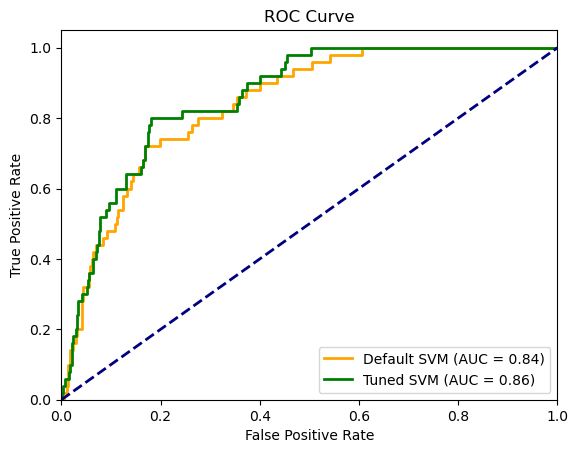

In [15]:
y_test_prob_default = svm_model.decision_function(X_test_processed)
y_test_prob_adjusted = svm_model_adjusted.decision_function(X_test_processed)


fpr_default, tpr_default, _ = roc_curve(y_test, y_test_prob_default)
roc_auc_default = auc(fpr_default, tpr_default)


fpr_adjusted, tpr_adjusted, _ = roc_curve(y_test, y_test_prob_adjusted)
roc_auc_adjusted = auc(fpr_adjusted, tpr_adjusted)


plt.figure()
lw = 2
plt.plot(fpr_default, tpr_default, color='orange', lw=lw, label='Default SVM (AUC = %0.2f)' % roc_auc_default)
plt.plot(fpr_adjusted, tpr_adjusted, color='green', lw=lw, label='Tuned SVM (AUC = %0.2f)' % roc_auc_adjusted)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()